# Cellular automata

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 5

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [343]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

In [344]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Zero-dimensional CA

Here's a simple implementation of the 0-D CA I mentioned in the book, with one cell.

In [345]:
n = 10
x = np.zeros(n)
print(x)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


To get the state of the cell in the next time step, we increment the current state mod 2.

In [346]:
x[1] = (x[0] + 1) % 2
x[1]

1.000

Filling in the rest of the array.

In [347]:
for i in range(2, 10):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[ 0.  1.  0.  1.  0.  1.  0.  1.  0.  1.]


So the behavior of this CA is simple: it blinks.

## One-dimensional CA

Just as we used a 1-D array to show the state of a single cell over time, we'll use a 2-D array to show the state of a 1-D CA over time, with one column per cell and one row per timestep.

In [348]:
rows = 10
cols = 22
array = np.zeros((rows, cols), dtype=np.int8)
array[0, 11] = 1
print(array)

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


To plot the array I use `plt.imshow`

In [349]:
def plot_ca(array):
    cmap = plt.get_cmap('Blues')
    plt.imshow(array, interpolation='none', cmap=cmap)

Here's what it looks like after we initialize the first row.

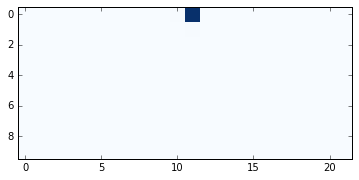

In [350]:
plot_ca(array)

And here's the function that fills in the next row.  The rule for this CA is to take the sum of a cell and its two neighbors mod 2.

In [351]:
def step(array, i):
    rows, cols = array.shape
    for j in range(1, cols):
        array[i, j] = sum(array[i-1, j-1:j+2]) % 2

Here's the second row.

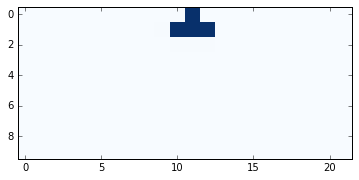

In [352]:
step(array, 1)
plot_ca(array)

And here's what it looks like with the rest of the cells filled in.

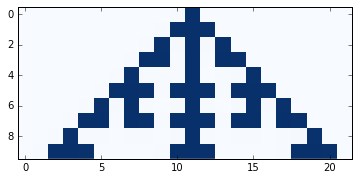

In [353]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

For a simple set of rules, the behavior is more interesting than you might expect.

**Exercise:** Modify this code to increase the number of rows and columns and see what this CA does after more time steps.

## Cross correlation

We can step the CA through time more quickly using "cross correlation".  To see how it works, the first step is to replace the slice operator with array multiplication.

This window selects the first three elements of an array:

In [354]:
window = np.zeros(cols, dtype=np.int8)
window[:3] = 1
print(window)
print(array[4])
print(window * array[4])

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Then we can use `sum` and the modulus operator to compute the state of the first cell during the next timestep.

In [355]:
sum(window * array[4]) % 2

0

To compute the state of the next cell, we shift the window to the right.

In [356]:
window = np.roll(window, 1)
print(window)

[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


And repeat the multiply-sum-modulus operations.

In [357]:
sum(window * array[4]) % 2

0

Now we can rewrite `step` using these operations.

In [358]:
def step2(array, i):
    rows, cols = array.shape
    window = np.zeros(cols)
    window[:3] = 1
    for j in range(1, cols):
        array[i, j] = sum(window * array[i-1]) % 2
        window = np.roll(window, 1)

And we can confirm that we get the same result.

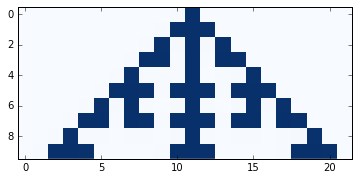

In [359]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

That sequence of operations is called a "sliding dot product" or "cross correlation", and NumPy provides a function that computes it.  So we can replace the `for` loop with `np.correlate`.  The parameter `mode='same'` means that the result has the same length as `array[i]`. 

In [360]:
def step3(array, i):
    window = np.array([1, 1, 1])
    array[i] = np.correlate(array[i-1], window, mode='same') % 2

And the result is the same.

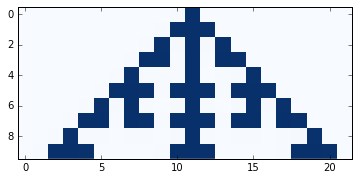

In [361]:
for i in range(1, rows):
    step3(array, i)

plot_ca(array)

So that's good enough for a CA that only depends on the total number of "on" cells, but for more general CAs, we need a table that maps from the configuration of the neighborhood to the future state of the center cell.

The following function makes the table by interpreting the Rule number in binary.

In [362]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    rule: int 0-255
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

Here's what it looks like as an array:

In [363]:
table = make_table(150)
print(table)

[0 1 1 0 1 0 0 1]


If we correlate the row with the window `[4, 2, 1]`, it treats each neighborhood as a binary number between 000 and 111.

In [364]:
window = [4, 2, 1]
corr = np.correlate(array[0], window, mode='same')
print(array[0])
print(corr)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 2 4 0 0 0 0 0 0 0 0 0]


Now we can use the result from `np.correlate` as an index into the table; the result is the next row of the array.

In [365]:
array[1] = table[corr]
print(array[1])

[0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]


We can wrap up that code in a function:

In [366]:
def step4(array, i):
    window = np.array([4, 2, 1])
    corr = np.correlate(array[i-1], window, mode='same')
    array[i] = table[corr]

And test it again.

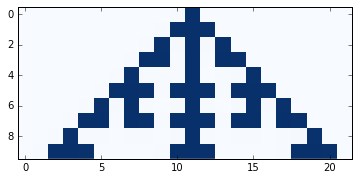

In [367]:
for i in range(1, rows):
    step4(array, i)

plot_ca(array)

How did I know that Rule 150 is the same as the previous CA?  I wrote out the table and converted it to binary.

## The Cell1D object

`Cell1D.py` provides a `Cell1D` class that encapsulates the code from the previous section.

Here's an example that runs a Rule 50 CA for 10 steps.

In [368]:
from Cell1D import Cell1D, Cell1DViewer

In [369]:
rule = 50
n = 10
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

We can display the results:

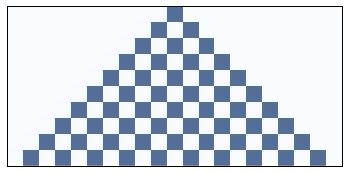

In [370]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-1.pdf')

Here's the Rule 50 table.

In [371]:
print(ca.table)

[0 1 0 0 1 1 0 0]


Another example:

In [372]:
rule = 150
n = 5
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

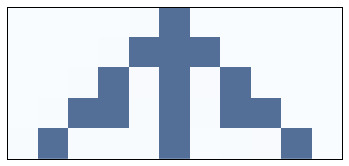

In [373]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-2.pdf')

And one more example showing recursive structure.

In [374]:
rule = 18
n = 64
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

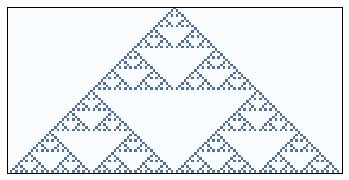

In [375]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-3.pdf')

Rule 30 generates a sequence of bits that is indistinguishable from random:

In [376]:
rule = 30
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

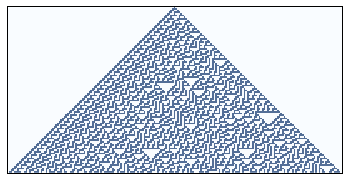

In [377]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-4.pdf')

And Rule 110 is Turing complete!

In [378]:
rule = 110
n = 100
ca = Cell1D(rule, n)
ca.start_single()
ca.loop(n-1)

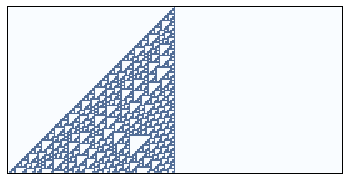

In [379]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-5.pdf')

Heres a longer run that has some spaceships.

In [380]:
rule = 110
n = 600
ca = Cell1D(rule, n)
ca.start_random()
ca.loop(n-1)

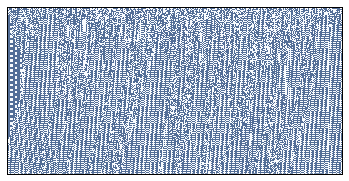

In [381]:
viewer = Cell1DViewer(ca)
viewer.draw()

plt.savefig('chap05-6.pdf')

## Exercises

**Exercise:** This exercise asks you to experiment with Rule 110 and see how
many spaceships you can find.

1. Read the [Wikipedia page about Rule 110](https://en.wikipedia.org/wiki/Rule_110), which describes its background pattern and spaceships.

2. Create a Rule 110 CA with an initial condition that yields the
  stable background pattern.  Note that the CA class provides
`start_string`, which allow you to initialize the state of
the array using a string of `1`s and `0`s.

3. Modify the initial condition by adding different patterns in the
  center of the row and see which ones yield spaceships.  You might
  want to enumerate all possible patterns of $n$ bits, for some
  reasonable value of $n$.  For each spaceship, can you find the
  period and rate of translation?  What is the biggest spaceship you
  can find?

4. What happens when spaceships collide?

#### Exercise 5.2

In [382]:
# Could not find start_string provided by CA class
# When checking answer saw how it was implemented there and modified my progress to use it

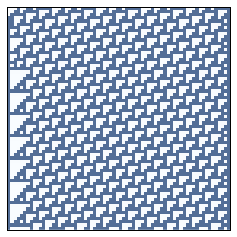

In [383]:
# Solution goes here

from Cell1D import Wrap1D
background = '00010011011111'
background = background * 5
rule = 110
n = len(background)
ca = Cell1D(rule, n, n)
ca.start_string(background)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()


In [384]:
# Solution goes here
print(ca.table)

[0 1 1 1 0 1 1 0]


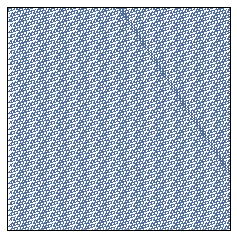

In [385]:
spaceship = '0001110111'; # From wikipedia
start_string_init = background*2 + spaceship + background*2
rule = 110
n = len(start_string_init)
ca = Cell1D(rule, n, n)
ca.start_string(start_string_init)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()


The diagonal line seen above is the spaceship.

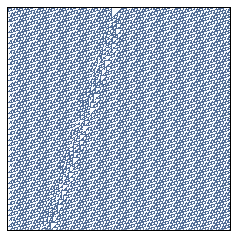

In [386]:
spaceship = '1111111111'; # Test
start_string_init = background*2 + spaceship + background*2
rule = 110
n = len(start_string_init)
ca = Cell1D(rule, n, n)
ca.start_string(start_string_init)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

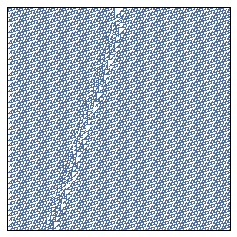

In [387]:
spaceship = '0000000000'; # Test
start_string_init = background*2 + spaceship + background*2
rule = 110
n = len(start_string_init)
ca = Cell1D(rule, n, n)
ca.start_string(start_string_init)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

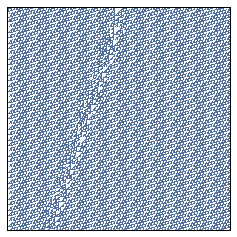

In [388]:
spaceship = '0101010101'; # Test
start_string_init = background*2 + spaceship + background*2
rule = 110
n = len(start_string_init)
ca = Cell1D(rule, n, n)
ca.start_string(start_string_init)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

In [389]:
# A little confused about how to determine what makes a spaceship "Big". 
# '1111111111' and '0000000000' seem big because the diagonal path they leave is wide,
# but I am pretty sure that is not how we are supposed to define bigness here.

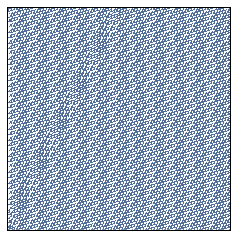

In [390]:
spaceship = '1100011101'; # Test
start_string_init = background*2 + spaceship + background*2
rule = 110
n = len(start_string_init)
ca = Cell1D(rule, n, n)
ca.start_string(start_string_init)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()

#### What happens when spaceships collide?

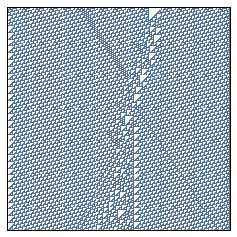

In [391]:
spaceship1 = '0001110111'; # From wikipedia
spaceship2 = '1111111111';
start_string_init = background + spaceship1 + background + spaceship2 + background
rule = 110
n = len(start_string_init)
ca = Cell1D(rule, n, n)
ca.start_string(start_string_init)
ca.loop(n-1)
viewer = Cell1DViewer(ca)
viewer.draw()


In [392]:
# Part of spaceship continues in the same direction, and part changes direction from collision as seen above.

**Exercise:** The goal of this exercise is to implement a Turing machine.

1. Read about Turing machines at http://en.wikipedia.org/wiki/Turing_machine.

2. Write a class called `Turing` that implements a Turing machine.  For the action table, use the rules for a 3-state busy beaver.

3. Write a class named `TuringDrawer` that generates an image that represents the state of the tape and the position and state of the head.  For one example of what that might look like, see http://mathworld.wolfram.com/TuringMachine.html.


#### Exercise 5.3

### My Solution
I struggled in my initial attempts to complete this exercise independently,
and found I was making little progress in learning the material,
so I referenced/relied on the following sources in addition to the wikipedia page.
- http://www.python-course.eu/turing_machine.php
- https://github.com/michaelamie/python-turing
- Solutions from ThinkComplexity

The code below is from those sources, but is heavily commented to show my understanding of how it works, and that I have learned the material the exercise is intended to teach.

In [393]:
class Tape(object):
    """Tape object initialize with rows of cells and an initial position."""
    def __init__(self, cells=[None], position=1):
        self.cells = cells
        self.position = position

    def write(self, symbol):
        if len(self.cells) >= self.position:
            self.cells[self.position-1] = symbol # Write symbol to tape

    def get_symbol(self):
        return self.cells[self.position - 1] # Read symbol from tape
   
    def get_tape_cells(self):
        return self.cells
    
    def set_position(self, pos):
        self.position = pos
    

class Turing():
    def __init__(self, action_table, initial_state, n, m):
        """
        action_table: dictionary mapping to next state
        n: number of rows
        m: number of columns
        """
        self.n = n # Number of rows 
        self.m = m # Number of columns
        # The tape cells are an array of zeros m wide and n tall. Type 8-bit integer.
        tape_cells = np.zeros((n,m), dtype=np.int8)
        self.tape = Tape(tape_cells) # The tape is a Tape object created with tape cells initialized at position=1.
        # Head is an array of zeros as long as the number of rows.Type 64-bit integer.
        self.head = np.zeros(n, dtype=np.int64) 
        self.head[0] = int(m/2) #  First element of the head (corresponding to first row of tape)
                                # is set to the integer value of half of the number of columns.
        self.state = initial_state # The state is initialized.
        # Because in this exercise the action table is following the rules of 3-state Busy Beaver,
        # the machine will switch between the states of A, B, C, and HALT.
        # When the current state is A, the next state will be B if the tape reads 0 and C if it reads 1
        # When the current state is B, the next state will be A if the tape reads 0 and stay B if it reads 1.
        # When the current state is C, the next state will be B if the tape reads 0 and HALT if it reads 1.
        # When the state is HALT the iterations will stop, raising an exception to break the loop.
        self.action_table = action_table # A dictionary of instructions mapping the machine to its next state.
                                         # See further explanation below, where busy beaver action_table is created.
        self.next = 1 # Initialized to 1 and incremented each step. Every step, the head of this index is recorded, 
                      # and the head of the previous next index is used to determine its current position.
        
    
    def loop(self, steps=1): 
        """
        Executes the given number of time steps.
        The input determines the maximum number of times to step through the loop.
        """
        for i in range(steps):
            try:
                self.step()         # Execute a time step of the machine
            except StopIteration:   # Unless StopIteration has been raised, which wouldd mean self.state = 'HALT'.
                break               # Once the HALT state is reached, the tape does not move
                                    # and the state does not change.

    def step(self):
        """Executes one time step."""
        if self.state == 'HALT':
            raise StopIteration     # HALT state has been reached. Stop iterating and break the loop.
        i = self.next # Set current index i equal to the next index of the head.
        head = self.head[i-1] # Set head equal to the machine's head at this step's previous index.
                              # (To read the symbol).
        
        symbol_array = self.tape.get_symbol()
        symbol = symbol_array[head]
        # The value of the new symbol to be written, which direction to move the tape, and what the next state is
        # are all found in the action_table using the symbol that was read and the current state.
        # New symbol = symbol to be written.
        new_symbol, move, self.state = self.action_table[symbol][self.state] 
        print(symbol, self.state, ': ', new_symbol, move, self.state)
        
        # Writing new symbol to the tape
        symbol_string=self.tape.cells[self.tape.position]
        symbol_string[head] = new_symbol
        self.tape.write(symbol_string)
        if move == 'R':
            head += 1    # If moving right, head increases by 1, effectively doing so.
            
      
        else:
            head -= 1    # If moving left, head decreases by 1, effectively doing so.
            
        self.head[i] = head  # The current value of head is set to have been the value of head at this step.
        self.next += 1  # Next counter increments.
                        # This new value will be set to be the index the next step in the loop.
    
    def get_array(self, start=0, end=None):
        """Gets a slice of columns from the CA.

        Avoids copying if possible.

        start: index of first column
        end: index of the last column plus one
        """
        if start==0 and end==None:
            return self.tape
        else:
            return self.tape[:, start:end]
        

In [394]:
# 3-state busy beaver action table
# This table can be found on the wikipedia for Turing Machines:
# https://en.wikipedia.org/wiki/Turing_machine_examples#3-state_Busy_Beaver
# This table functions as a look up table to determine
# the value to write(in this case alwasy 1), the direction to move (Either L or R),
# and the next state. (A, B, C, or HALT).

busy_beaver_action_table = {}
busy_beaver_action_table[0]= {}
busy_beaver_action_table[1]= {}
busy_beaver_action_table[0]['A']= 1, 'R', 'B' 
busy_beaver_action_table[0]['B'] = 1, 'L', 'A' 
busy_beaver_action_table[0]['C'] = 1, 'L', 'B'
busy_beaver_action_table[1]['A'] = 1, 'L', 'C' 
busy_beaver_action_table[1]['B'] = 1, 'R', 'B' 
busy_beaver_action_table[1]['C'] = 1, 'R', 'HALT'

In [395]:
turing = Turing(busy_beaver_action_table, 'A', 20, 20) # Create turing with 20x20 tape and initialize to state 'A'.
turing.loop(19) # loop up to 20 times through steps (or until halt which occurs here after 13 steps).

0 B :  1 R B
0 A :  1 L A
1 C :  1 L C
0 B :  1 L B
0 A :  1 L A
0 B :  1 R B
1 B :  1 R B
1 B :  1 R B
1 B :  1 R B
1 B :  1 R B
0 A :  1 L A
1 C :  1 L C
1 HALT :  1 R HALT


[[0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


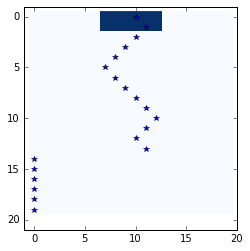

In [396]:
class TuringDrawer:        
    def draw_turing_image(self, turing):
        """Draws the turing image"""
        n = turing.n
        m = turing.m
        tape = turing.tape.get_tape_cells()
        print(tape)
        plt.ylim([n + 1, -1])
        plt.xlim([-1, m])
        
        plt.imshow(tape, cmap='Blues',  interpolation='nearest')
        
        x = turing.head
        y = np.arange(len(x))
        plt.plot(x, y, '*')

turing_image = TuringDrawer()
turing_image.draw_turing_image(turing)

The final position of my tape looks different than the solution. This appears to be an issue with my tape class, since the head points look correct. I thought it may have been a problem with incrementing the position in the tape object, but changing that only made the points also incorrect, and appeared to make the problem worse.
There is a misunderstanding here somewhere. Would love to discuss in person if you think that would be useful, though feedback to the assignment might be sufficient. (I understand that this isn't wokring because I'm not reading and writing enough symbols on the tape past the first two rows, but I can't find the best place to increment which row of cells I am looking at. The options that seemed intuitive to me, such as incrementing the tape position(not head) when the index i of the next step increments, or incrementing the position when moving the tape left/right all made my final result look worse. I'm currently moving the head when the action table says to move left/right. 

Still figuring this out and may submit a revision late if possible.

**Exercise:** This exercise asks you to implement and test several PRNGs.
For testing, you will need to install 
`DieHarder`, which you can download from 
https://www.phy.duke.edu/~rgb/General/dieharder.php, or it
might be available as a package for your operating system.

1. Write a program that implements one of the linear congruential
generators described at http://en.wikipedia.org/wiki/Linear_congruential_generator}.
Test it using `DieHarder`.

2. Read the documentation of Python's `random` module.
What PRNG does it use?  Test it.

3. Implement a Rule 30 CA with a few hundred cells,
run it for as many time steps as you can in a reasonable amount
of time, and output the center column as a sequence of bits.
Test it.


In [398]:
# Did not complete optional exercies.